# Panel Data Forecasting: An M3 Competition Case Study

This chapter brings everything together in a complete, end-to-end forecasting workflow using the **M3 Competition** dataset Makridakis & Hibon (2000). We replicate a realistic forecasting project: loading data, exploring patterns, specifying multiple models, fitting in parallel across hundreds of series, generating forecasts, and evaluating accuracy.

## The M3 Competition

The M3 Competition (Makridakis & Hibon, 2000) is one of the most influential forecasting competitions. It contains **3,003 time series** from six domains:

| Domain | Yearly | Quarterly | Monthly | Total |
|--------|--------|-----------|---------|-------|
| MICRO | 146 | 204 | 474 | 824 |
| MACRO | 83 | 99 | 312 | 494 |
| INDUSTRY | 102 | 83 | 334 | 519 |
| FINANCE | 58 | 76 | 145 | 279 |
| DEMOGRAPHIC | 245 | 57 | 111 | 413 |
| OTHER | 11 | 37 | 52 | 100 |
| **Total** | **645** | **556** | **1,428** | **3,003** |

Each series has a training portion (`x`) and a hold-out test portion (`xx`) with standardised horizons:

| Frequency | Test Horizon ($h$) |
|-----------|-------------------|
| Yearly | 6 |
| Quarterly | 8 |
| Monthly | 18 |

## Step 1: Data Loading and Inspection

In [1]:
using Durbyn
using Durbyn.TableOps
using Durbyn.Grammar
using Durbyn.ModelSpecs
using CSV, Tables, Plots
import Durbyn: plot

# Load all three frequencies
data_dir = joinpath(@__DIR__, "..", "data")

tbl_monthly   = Tables.columntable(CSV.File(joinpath(data_dir, "M3_MONTHLY.csv")))
tbl_quarterly = Tables.columntable(CSV.File(joinpath(data_dir, "M3_QUARTERLY.csv")))
tbl_yearly    = Tables.columntable(CSV.File(joinpath(data_dir, "M3_YEARLY.csv")))

# Quick inspection
println("=== M3 Monthly ===")
glimpse(tbl_monthly)

println("\n=== M3 Quarterly ===")
glimpse(tbl_quarterly)

println("\n=== M3 Yearly ===")
glimpse(tbl_yearly)

=== M3 Monthly ===
Table glimpse
  Rows: 167562
  Columns: 9
  data                :: String3  [String3("M3"), String3("M3"), String3("M3"), String3("M3"), String3("M3"), …]
  series              :: String7  [String7("N1402"), String7("N1402"), String7("N1402"), String7("N1402"), String7("N1402"), …]
  period              :: String7  [String7("MONTHLY"), String7("MONTHLY"), String7("MONTHLY"), String7("MONTHLY"), String7("MONTHLY"), …]
  type                :: String15  [String15("MICRO"), String15("MICRO"), String15("MICRO"), String15("MICRO"), String15("MICRO"), …]
  description         :: String  ["SHIPMENTS (Code TD-30EXP)", "SHIPMENTS (Code TD-30EXP)", "SHIPMENTS (Code TD-30EXP)", "SHIPMENTS (Code TD-30EXP)", "SHIPMENTS (Code TD-30EXP)", …]
  value_type          :: String3  [String3("x"), String3("x"), String3("x"), String3("x"), String3("x"), …]
  time                :: Float64  [1990.0, 1990.08333333333, 1990.16666666667, 1990.25, 1990.33333333333, …]
  date                :: Da


## Step 2: Data Preparation

### Splitting Train and Test

In [2]:
# Monthly
train_m = query(tbl_monthly, row -> row.value_type == "x")
test_m  = query(tbl_monthly, row -> row.value_type == "xx")

# Quarterly
train_q = query(tbl_quarterly, row -> row.value_type == "x")
test_q  = query(tbl_quarterly, row -> row.value_type == "xx")

# Yearly
train_y = query(tbl_yearly, row -> row.value_type == "x")
test_y  = query(tbl_yearly, row -> row.value_type == "xx")

# Verify counts
for (name, train, test) in [
    ("Monthly", train_m, test_m),
    ("Quarterly", train_q, test_q),
    ("Yearly", train_y, test_y)
]
    n_series = length(unique(train.series))
    n_train = length(train.value)
    n_test = length(test.value)
    println("$name: $n_series series | Train: $n_train obs | Test: $n_test obs")
end

Monthly: 1428 series | Train: 141858 obs | Test: 25704 obs
Quarterly: 756 series | Train: 30956 obs | Test: 6048 obs
Yearly: 645 series | Train: 14449 obs | Test: 3870 obs



### Selecting Relevant Columns

In [3]:
# Keep only the columns needed for modelling
train_m = select(train_m, :series, :type, :date, :value)
test_m  = select(test_m,  :series, :date, :value)

train_q = select(train_q, :series, :type, :date, :value)
test_q  = select(test_q,  :series, :date, :value)

train_y = select(train_y, :series, :type, :date, :value)
test_y  = select(test_y,  :series, :date, :value)

(series = String7["N0001", "N0001", "N0001", "N0001", "N0001", "N0001", "N0002", "N0002", "N0002", "N0002"  …  "N0644", "N0644", "N0644", "N0644", "N0645", "N0645", "N0645", "N0645", "N0645", "N0645"], date = [Dates.Date("1989-01-01"), Dates.Date("1990-01-01"), Dates.Date("1991-01-01"), Dates.Date("1992-01-01"), Dates.Date("1993-01-01"), Dates.Date("1994-01-01"), Dates.Date("1989-01-01"), Dates.Date("1990-01-01"), Dates.Date("1991-01-01"), Dates.Date("1992-01-01")  …  Dates.Date("1951-01-01"), Dates.Date("1952-01-01"), Dates.Date("1953-01-01"), Dates.Date("1954-01-01"), Dates.Date("1987-01-01"), Dates.Date("1988-01-01"), Dates.Date("1989-01-01"), Dates.Date("1990-01-01"), Dates.Date("1991-01-01"), Dates.Date("1992-01-01")], value = [5379.75, 6158.68, 6876.58, 7851.91, 8407.84, 9156.01, 4793.2, 5602.0, 5065.0, 5056.0  …  7050.0, 7070.0, 3780.0, 4230.0, 7068.0, 7343.0, 5730.0, 5007.0, 4715.0, 4001.0])


## Step 3: Exploratory Data Analysis

### Series-Level Summary Statistics

In [4]:
import Statistics: mean, std
# Monthly series statistics
monthly_stats = summarise(
    groupby(train_m, :series),
    type     = g -> first(g.type),
    n        = g -> length(g.value),
    mean     = g -> round(mean(g.value), digits=2),
    std      = g -> round(std(g.value), digits=2),
    cv       = g -> round(std(g.value) / abs(mean(g.value)), digits=3),
    min      = g -> minimum(g.value),
    max      = g -> maximum(g.value)
)

glimpse(monthly_stats)

Table glimpse
  Rows: 1428
  Columns: 8
  series              :: String7  [String7("N1402"), String7("N1403"), String7("N1404"), String7("N1405"), String7("N1406"), …]
  type                :: String15  [String15("MICRO"), String15("MICRO"), String15("MICRO"), String15("MICRO"), String15("MICRO"), …]
  n                   :: Int64  [50, 50, 50, 50, 50, …]
  mean                :: Float64  [3609.6, 1593.6, 3909.0, 2582.4, 5870.0, …]
  std                 :: Float64  [1950.35, 1422.97, 1811.27, 1916.81, 3198.79, …]
  cv                  :: Float64  [0.54, 0.893, 0.463, 0.742, 0.545, …]
  min                 :: Float64  [480.0, 120.0, 720.0, 180.0, 600.0, …]
  max                 :: Float64  [9000.0, 7440.0, 8760.0, 7780.0, 12050.0, …]



### Distribution by Domain

In [5]:
# Count series by domain type
domain_summary = summarise(
    groupby(monthly_stats, :type),
    n_series  = g -> length(g.series),
    avg_len   = g -> round(mean(g.n), digits=1),
    avg_cv    = g -> round(mean(g.cv), digits=3),
    min_len   = g -> minimum(g.n),
    max_len   = g -> maximum(g.n)
)

glimpse(domain_summary)

Table glimpse
  Rows: 6
  Columns: 6
  type                :: String15  [String15("DEMOGRAPHIC"), String15("FINANCE"), String15("INDUSTRY"), String15("MACRO"), String15("MICRO"), …]
  n_series            :: Int64  [111, 145, 334, 312, 474, …]
  avg_len             :: Float64  [105.3, 106.4, 122.0, 112.9, 74.7, …]
  avg_cv              :: Float64  [0.165, 0.279, 0.21, 0.143, 0.321, …]
  min_len             :: Int64  [53, 50, 78, 48, 50, …]
  max_len             :: Int64  [120, 126, 126, 126, 108, …]



### Visualising Sample Series

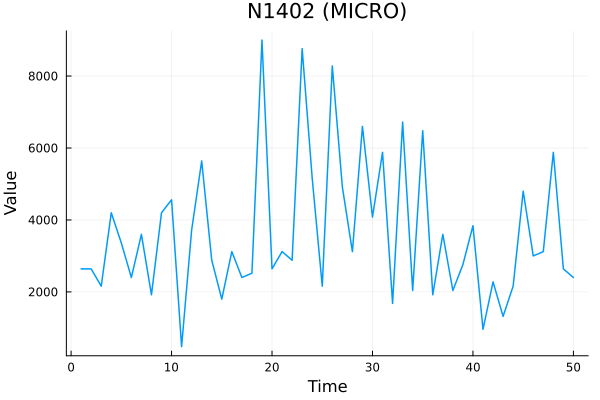

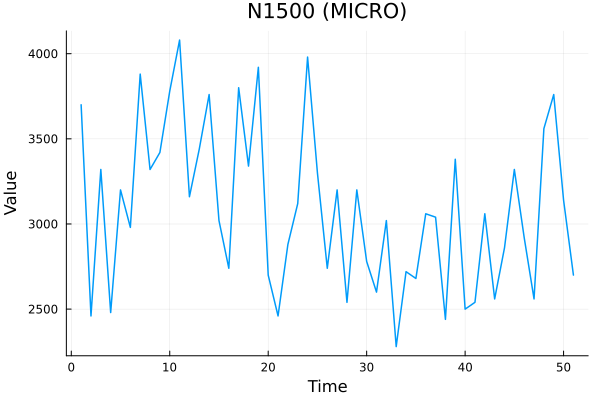

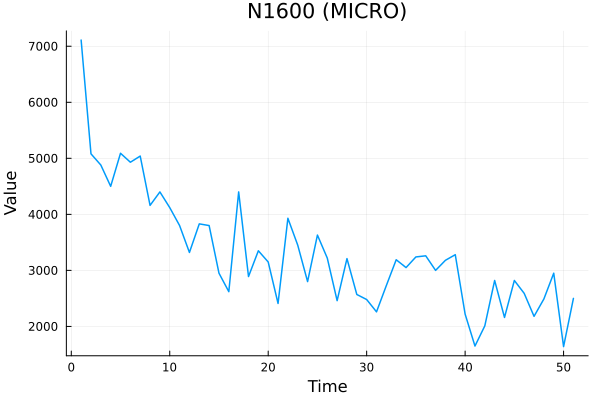

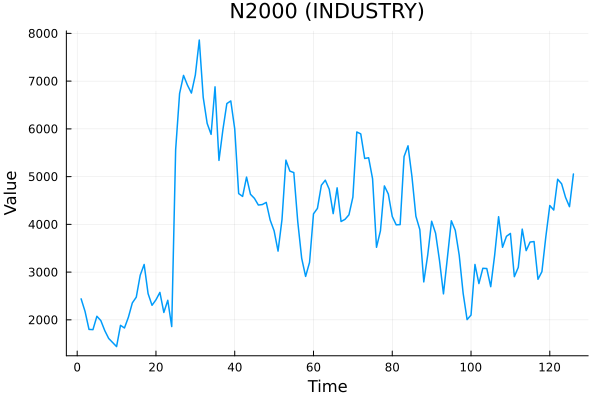

In [6]:
# Plot a few series from different domains
sample_series = ["N1402", "N1500", "N1600", "N2000"]

for sid in sample_series
    s = query(train_m, row -> row.series == sid)
    y_vals = Float64.(s.value)
    p = Plots.plot(y_vals,
        title = "$sid ($(first(s.type)))",
        xlabel = "Time", ylabel = "Value",
        legend = false, linewidth = 1.5
    )
    display(p)
end


### Diagnostic Analysis of a Representative Series

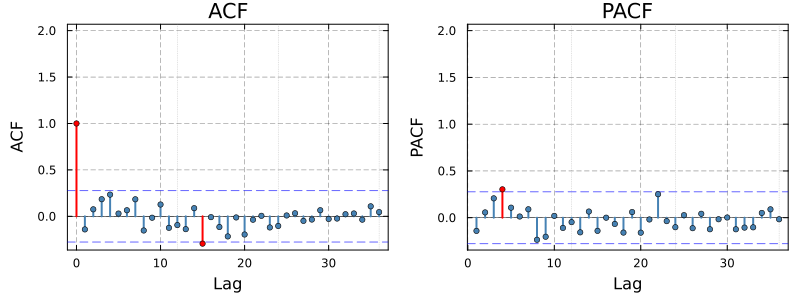

In [7]:
# Pick one series for deep diagnostics
sid = "N1402"
s_data = query(train_m, row -> row.series == sid)
y = Float64.(s_data.value)
m = 12
# ACF/PACF
p1 = plot(acf(y, m, 36), title="ACF")
p2 = plot(pacf(y, m, 36), title="PACF")
Plots.plot(p1, p2, layout=(1, 2), size=(800, 300))

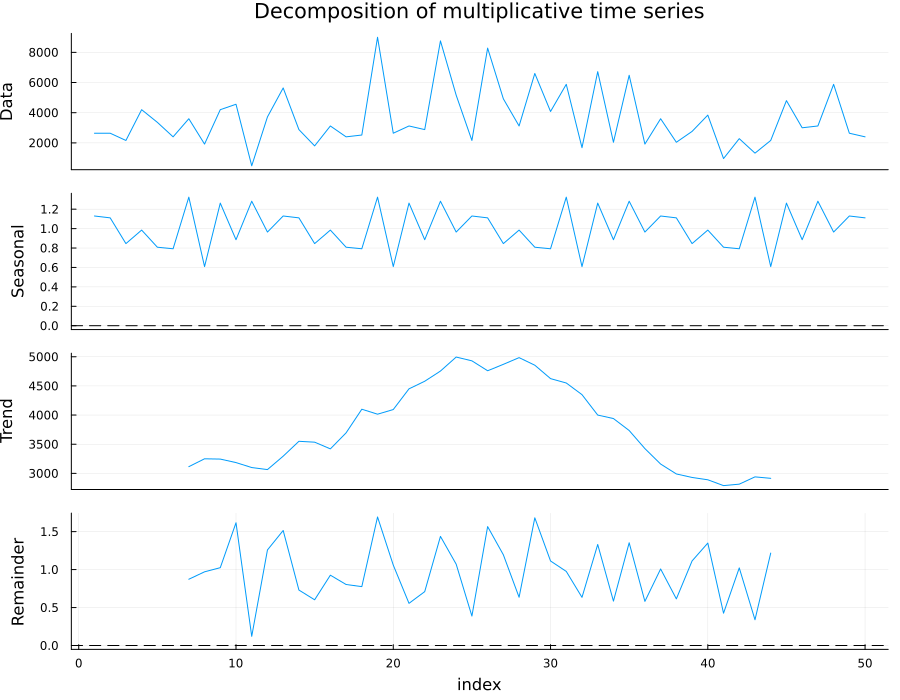

In [8]:
import Durbyn: decompose

# Decomposition
dec = decompose(x=y, m=m, type=:multiplicative)
plot(dec)

In [9]:
import Durbyn: seasonal_strength, ndiffs, nsdiffs, box_cox_lambda

# Seasonal strength
fs = seasonal_strength(y, m)
println("Seasonal strength for $sid: $fs")

# Stationarity
n_d = ndiffs(y)
n_D = nsdiffs(y, m)
println("Differencing needed: d=$n_d, D=$n_D")

# Box-Cox
lambda = box_cox_lambda(y, m)
println("Recommended λ = $lambda")

Seasonal strength for N1402: [0.22758468887332306]
Differencing needed: d=0, D=0
Recommended λ = -0.7053543105886625



## Step 4: Model Specification

We define a comprehensive model collection that covers the major forecasting paradigms:

In [10]:

models = model(
      NaiveSpec(@formula(value = naive_term())),
      SnaiveSpec(@formula(value = snaive_term())),
      ArarSpec(@formula(value = arar())),
      ArarmaSpec(@formula(value = p() + q())),
      ArimaSpec(@formula(value = p() + q() + P() + Q() + d() + D())),
      BatsSpec(@formula(value = bats())),
      TbatsSpec(@formula(value = tbats())),
      EtsSpec(@formula(value = e("Z") + t("Z") + s("Z") + drift())),
      SesSpec(@formula(value = ses())),
      HoltSpec(@formula(value = holt(damped=true))),
      HoltWintersSpec(@formula(value = hw(seasonal=:multiplicative))),
      CrostonSpec(@formula(value = croston(method=:sba))),
      ThetaSpec(@formula(value = theta())),
      names=[ "naive", "snaive", "arar", "ararma", "arima", "bats", "tbats", "ets", "ses", "holt", "hw", "croston", "theta",]
    )

ModelCollection with 13 models


## Step 5: Model Fitting

### Creating PanelData

In [11]:
# Monthly panel
panel_m = PanelData(
    select(train_m, :series, :date, :value);
    groupby = :series,
    date = :date,
    m = 12)
    
glimpse(panel_m)

PanelData glimpse
  Groups: series
  Date: date
  Seasonal period m: 12
Table glimpse
  Rows: 141858
  Columns: 3
  series              :: String7  [String7("N1402"), String7("N1402"), String7("N1402"), String7("N1402"), String7("N1402"), …]
  date                :: Dates.Date  [Dates.Date("1990-01-01"), Dates.Date("1990-02-01"), Dates.Date("1990-03-01"), Dates.Date("1990-04-01"), Dates.Date("1990-05-01"), …]
  value               :: Float64  [2640.0, 2640.0, 2160.0, 4200.0, 3360.0, …]



### Fitting All Models

In [12]:
# JIT warm-up: fit each model once on a single short series
# This compiles all code paths so the timed run below reflects pure computation
println("JIT warm-up (compiling all model code paths)...")
warmup_series = first(unique(train_m.series))
warmup_data = query(train_m, row -> row.series == warmup_series)
warmup_panel = PanelData(
    select(warmup_data, :series, :date, :value);
    groupby = :series, date = :date, m = 12
)
@time fit(models, warmup_panel)
println("Warm-up complete. All models compiled.")

JIT warm-up (compiling all model code paths)...


┌ Info: Grouping data by series...
└ @ Durbyn.ModelSpecs /home/akayr/Development/Open Source/Julia/Durbyn.jl/src/ModelSpecs/fit_grouped.jl:17
┌ Info: Found 1 groups
└ @ Durbyn.ModelSpecs /home/akayr/Development/Open Source/Julia/Durbyn.jl/src/ModelSpecs/fit_grouped.jl:20
┌ Info: Fitting models in parallel (20 threads)...
└ @ Durbyn.ModelSpecs /home/akayr/Development/Open Source/Julia/Durbyn.jl/src/ModelSpecs/fit_grouped.jl:26
┌ Info:   Progress: 1/1 (100.0%)
└ @ Durbyn.ModelSpecs /home/akayr/Development/Open Source/Julia/Durbyn.jl/src/ModelSpecs/fit_grouped.jl:47
┌ Info: Completed in 0.34s
└ @ Durbyn.ModelSpecs /home/akayr/Development/Open Source/Julia/Durbyn.jl/src/ModelSpecs/fit_grouped.jl:77
┌ Info: Grouping data by series...
└ @ Durbyn.ModelSpecs /home/akayr/Development/Open Source/Julia/Durbyn.jl/src/ModelSpecs/fit_grouped.jl:17
┌ Info: Found 1 groups
└ @ Durbyn.ModelSpecs /home/akayr/Development/Open Source/Julia/Durbyn.jl/src/ModelSpecs/fit_grouped.jl:20
┌ Info: Fitting models i

 54.275736 seconds (262.41 M allocations: 12.843 GiB, 3.47% gc time, 129.85% compilation time: <1% of which was recompilation)
Warm-up complete. All models compiled.

┌ Info:   Progress: 1/1 (100.0%)
└ @ Durbyn.ModelSpecs /home/akayr/Development/Open Source/Julia/Durbyn.jl/src/ModelSpecs/fit_grouped.jl:47
┌ Info: Completed in 3.26s
└ @ Durbyn.ModelSpecs /home/akayr/Development/Open Source/Julia/Durbyn.jl/src/ModelSpecs/fit_grouped.jl:77


In [13]:
# Fit all models to all monthly series
# This runs in parallel across threads!
# Start Julia with: julia -t auto
println("Fitting $(length(unique(train_m.series))) series × 13 models...")
@time fitted_m = fit(models, panel_m)
fitted_m

Fitting 1428 series × 13 models...


┌ Info: Grouping data by series...
└ @ Durbyn.ModelSpecs /home/akayr/Development/Open Source/Julia/Durbyn.jl/src/ModelSpecs/fit_grouped.jl:17
┌ Info: Found 1428 groups
└ @ Durbyn.ModelSpecs /home/akayr/Development/Open Source/Julia/Durbyn.jl/src/ModelSpecs/fit_grouped.jl:20
┌ Info: Fitting models in parallel (20 threads)...
└ @ Durbyn.ModelSpecs /home/akayr/Development/Open Source/Julia/Durbyn.jl/src/ModelSpecs/fit_grouped.jl:26
┌ Info:   Progress: 71/1428 (5.0%)
└ @ Durbyn.ModelSpecs /home/akayr/Development/Open Source/Julia/Durbyn.jl/src/ModelSpecs/fit_grouped.jl:47
┌ Info:   Progress: 213/1428 (14.9%)
└ @ Durbyn.ModelSpecs /home/akayr/Development/Open Source/Julia/Durbyn.jl/src/ModelSpecs/fit_grouped.jl:47
┌ Info:   Progress: 284/1428 (19.9%)
└ @ Durbyn.ModelSpecs /home/akayr/Development/Open Source/Julia/Durbyn.jl/src/ModelSpecs/fit_grouped.jl:47
┌ Info:   Progress: 852/1428 (59.7%)
└ @ Durbyn.ModelSpecs /home/akayr/Development/Open Source/Julia/Durbyn.jl/src/ModelSpecs/fit_grouped

575.348479 seconds (14.47 G allocations: 1.689 TiB, 26.97% gc time, 47 lock conflicts, 9.05% compilation time)


┌ Info: Completed in 35.11s
└ @ Durbyn.ModelSpecs /home/akayr/Development/Open Source/Julia/Durbyn.jl/src/ModelSpecs/fit_grouped.jl:77


FittedModelCollection with 13 fitted models

> 💡 **Tip**: Performance with Threading
>
>
> For 1,428 monthly series and 13 models, Durbyn fits **18,564 models**. With multi-threading:
>
> | Cores | Approximate Time |
> |-------|-----------------|
> | 1 | Baseline |
> | 8 | ~8x faster |
> | 32 | ~20x faster |
> | 96 | ~30x+ faster |
>
> Always start Julia with `julia -t auto` for panel data work.


## Step 6: Forecasting

In [15]:
# Generate 18-step-ahead forecasts (M3 monthly test horizon)
fc_m = forecast(fitted_m, h=18)

# Convert to tidy table
fc_tbl = as_table(fc_m)
glimpse(fc_tbl)

# How many forecasts?
println("Total forecast rows: $(length(fc_tbl.mean))")

Table glimpse
  Rows: 334152
  Columns: 9
  series              :: String7  [String7("N1402"), String7("N1402"), String7("N1402"), String7("N1402"), String7("N1402"), …]
  step                :: Int64  [1, 2, 3, 4, 5, …]
  mean                :: Float64  [2400.0, 2400.0, 2400.0, 2400.0, 2400.0, …]
  lower_80            :: Union{Missing, Float64}  [-1364.926283982591, -2924.409812143119, -4121.043610609338, -5129.852567965182, -6018.631101260751, …]
  upper_80            :: Union{Missing, Float64}  [6164.9262839825915, 7724.409812143119, 8921.043610609338, 9929.852567965183, 10818.631101260751, …]
  lower_95            :: Union{Missing, Float64}  [-3357.9578687638095, -5742.982109578662, -7573.075576539928, -9115.915737527619, -10475.185206135693, …]
  upper_95            :: Union{Missing, Float64}  [8157.9578687638095, 10542.982109578661, 12373.075576539928, 13915.915737527619, 15275.185206135693, …]
  model               :: String  ["Naive method", "Naive method", "Naive method", "Nai


## Step 7: Accuracy Evaluation

### Computing Accuracy Metrics

In [16]:
# Compute accuracy against the held-out test data
acc_m = accuracy(fc_m, test_m)
glimpse(acc_m)

Table glimpse
  Rows: 18564
  Columns: 8
  model               :: Any  ["naive", "naive", "naive", "naive", "naive", …]
  MPE                 :: Any  [-12.473004185280255, -4.073228428615475, 3.515996762116332, 22.311603754363162, 1.8615294784314098, …]
  ME                  :: Any  [-337.77777777777777, -111.11111111111111, 191.61111111111111, 445.8333333333333, 186.11111111111111, …]
  series              :: Any  [String7("N1823"), String7("N1687"), String7("N2066"), String7("N2187"), String7("N2466"), …]
  RMSE                :: Any  [535.4126134736337, 591.9084013219914, 265.60737523227357, 580.433243362232, 648.6096240763349, …]
  MAE                 :: Any  [471.1111111111111, 375.55555555555554, 232.83333333333334, 445.8333333333333, 525.0, …]
  MAPE                :: Any  [15.956488398761214, 8.53123330627557, 4.385712682832163, 22.311603754363162, 7.414963561451513, …]
  ACF1                :: Any  [0.2494260986792321, 0.2853903182186379, -0.343466148799702, -0.255257768892238


The accuracy table contains metrics for each (series, model) combination:

- **ME**: Mean Error
- **RMSE**: Root Mean Squared Error
- **MAE**: Mean Absolute Error
- **MAPE**: Mean Absolute Percentage Error
- **MASE**: Mean Absolute Scaled Error (scaled by in-sample naive error)
- **sMAPE**: Symmetric MAPE

### Aggregating by Model

In [17]:
# Average accuracy across all series, by model
model_accuracy = summarise(
    groupby(acc_m, :model),
    avg_MPE  = g -> round(mean(g.MPE), digits=2),
    avg_ME  = g -> round(mean(g.ME), digits=3),
    avg_RMSE = g -> round(mean(g.RMSE), digits=2),
    avg_MAE  = g -> round(mean(g.MAE), digits=2),
    avg_MAPE  = g -> round(mean(g.MAPE), digits=2),
    avg_ACF1  = g -> round(mean(g.ACF1), digits=2),
    n_series  = g -> length(g.series)
)

# Sort by average MAPE
model_accuracy = arrange(model_accuracy, :avg_MAPE)
glimpse(model_accuracy)

Table glimpse
  Rows: 13
  Columns: 8
  model               :: String  ["ets", "snaive", "arima", "hw", "ararma", …]
  avg_MPE             :: Float64  [-8.0, -5.55, -10.1, -10.33, -13.66, …]
  avg_ME              :: Float64  [24.922, 116.336, -41.798, -44.932, -147.969, …]
  avg_RMSE            :: Float64  [751.06, 950.82, 779.44, 816.27, 830.76, …]
  avg_MAE             :: Float64  [621.81, 788.86, 649.0, 678.31, 691.17, …]
  avg_MAPE            :: Float64  [19.05, 20.93, 21.89, 22.71, 22.94, …]
  avg_ACF1            :: Float64  [0.32, 0.29, 0.33, 0.31, 0.32, …]
  n_series            :: Int64  [1428, 1428, 1428, 1428, 1428, …]



### Aggregating by Domain and Model

In [18]:
# Join accuracy with domain type information
series_types = distinct(select(train_m, :series, :type))
acc_with_type = left_join(acc_m, series_types, by=:series)

# Accuracy by domain and model
domain_model_acc = summarise(
    groupby(acc_with_type, :type, :model),
    avg_MAPE = g -> round(mean(g.MAPE), digits=2),
    avg_MAE  = g -> round(mean(g.MAE), digits=3),
    n         = g -> length(g.series)
)

glimpse(domain_model_acc)

Table glimpse
  Rows: 78
  Columns: 5
  type                :: String15  [String15("DEMOGRAPHIC"), String15("DEMOGRAPHIC"), String15("DEMOGRAPHIC"), String15("DEMOGRAPHIC"), String15("DEMOGRAPHIC"), …]
  model               :: String  ["arar", "ararma", "arima", "bats", "croston", …]
  avg_MAPE            :: Float64  [16.92, 14.25, 14.82, 11.1, 18.64, …]
  avg_MAE             :: Float64  [474.665, 428.662, 468.031, 419.503, 688.996, …]
  n                   :: Int64  [111, 111, 111, 111, 111, …]



### Finding Winners

In [19]:
# Which model wins (lowest sMAPE) for each series?
best_per_series = summarise(
    groupby(acc_m, :series),
    best_model = g -> begin
        idx = argmin(g.MAPE)
        g.model[idx]
    end,
    best_MAPE = g -> round(minimum(g.MAPE), digits=2)
)

# Count wins per model
win_counts = summarise(
    groupby(best_per_series, :best_model),
    wins = g -> length(g.series)
)

win_counts = arrange(win_counts, :wins)  # ascending
glimpse(win_counts)
win_counts = arrange(win_counts, :wins => :desc)  # decending
glimpse(win_counts)

Table glimpse
  Rows: 12
  Columns: 2
  best_model          :: String  ["ses", "holt", "naive", "bats", "snaive", …]
  wins                :: Int64  [43, 54, 83, 86, 99, …]
Table glimpse
  Rows: 12
  Columns: 2
  best_model          :: String  ["hw", "ararma", "arima", "croston", "ets", …]
  wins                :: Int64  [221, 163, 155, 142, 135, …]



## Step 8: Visualisation

### Plotting Forecasts

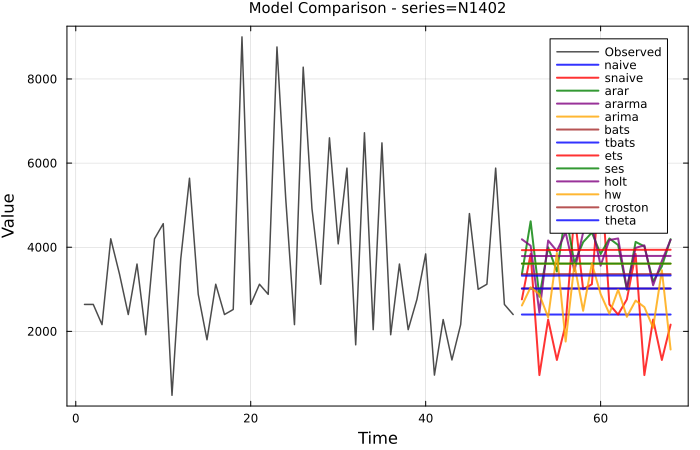

In [20]:
# Quick look at first series
plot(fc_m)

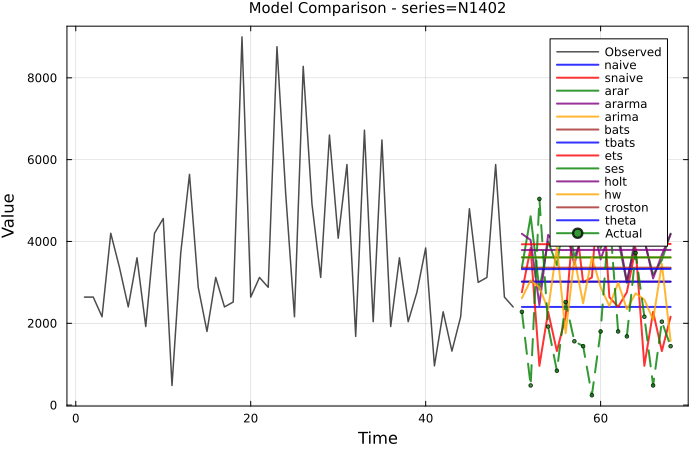

In [21]:
# Detailed plot for one series with actuals
plot(fc_m, series="N1402", actual=test_m)

Best: N2698 (MAPE=0.08)
Worst: N2602 (MAPE=1003.55)


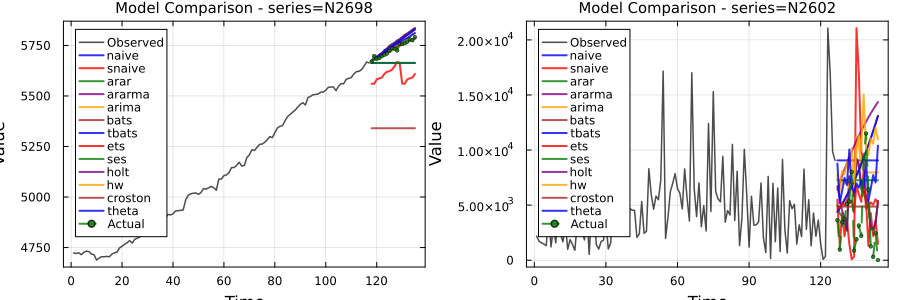

In [22]:

# Find best and worst performing series
best_series = best_per_series.series[argmin(best_per_series.best_MAPE)]
worst_series = best_per_series.series[argmax(best_per_series.best_MAPE)]

println("Best: $best_series (MAPE=$(minimum(best_per_series.best_MAPE)))")
println("Worst: $worst_series (MAPE=$(maximum(best_per_series.best_MAPE)))")

plot(fc_m, series=[best_series, worst_series], facet=true, actual=test_m)


## Step 9: Quarterly and Yearly Data

Repeat the workflow for the other frequencies:

### Quarterly

In [23]:
# Panel data
panel_q = PanelData(
    select(train_q, :series, :date, :value);
    groupby=:series, date=:date, m=4
)

# Model collection (adjust seasonal parameters)
models_q = model(
    ArimaSpec(@formula(value = p() + q() + d() + P() + Q() + D())),
    EtsSpec(@formula(value = e("Z") + t("Z") + s("Z") + drift(:auto))),
    ThetaSpec(@formula(value = theta())),
    BatsSpec(@formula(value = bats())),
    TbatsSpec(@formula(value = tbats())),
    HoltWintersSpec(@formula(value = hw(seasonal=:multiplicative))),
    SnaiveSpec(@formula(value = snaive_term())),
    names=["ARIMA", "ETS", "Theta", "BATS", "TBATS", "HW_mul", "SNaive"]
)

# Fit, forecast, evaluate
fitted_q = fit(models_q, panel_q, m=4)
fc_q = forecast(fitted_q, h=8)
acc_q = accuracy(fc_q, test_q)

┌ Info: Grouping data by series...
└ @ Durbyn.ModelSpecs /home/akayr/Development/Open Source/Julia/Durbyn.jl/src/ModelSpecs/fit_grouped.jl:159
┌ Info: Found 756 groups
└ @ Durbyn.ModelSpecs /home/akayr/Development/Open Source/Julia/Durbyn.jl/src/ModelSpecs/fit_grouped.jl:163
┌ Info: Fitting models in parallel (20 threads)...
└ @ Durbyn.ModelSpecs /home/akayr/Development/Open Source/Julia/Durbyn.jl/src/ModelSpecs/fit_grouped.jl:174
┌ Info:   Progress: 37/756 (4.9%)
└ @ Durbyn.ModelSpecs /home/akayr/Development/Open Source/Julia/Durbyn.jl/src/ModelSpecs/fit_grouped.jl:193
┌ Info:   Progress: 74/756 (9.8%)
└ @ Durbyn.ModelSpecs /home/akayr/Development/Open Source/Julia/Durbyn.jl/src/ModelSpecs/fit_grouped.jl:193
┌ Warning: Having 3 or more differencing operations is not recommended. Consider reducing the total number of differences.
└ @ Durbyn.Arima /home/akayr/Development/Open Source/Julia/Durbyn.jl/src/Models/Arima/auto_arima.jl:277
┌ Warning: Having 3 or more differencing operations is

(model = Any["ARIMA", "ARIMA", "ARIMA", "ARIMA", "ARIMA", "ARIMA", "ARIMA", "ARIMA", "ARIMA", "ARIMA"  …  "SNaive", "SNaive", "SNaive", "SNaive", "SNaive", "SNaive", "SNaive", "SNaive", "SNaive", "SNaive"], MPE = Any[18.06348687860207, 1.8027836096574066, 17.66220386440491, -2.212787118087567, -34.44417500011708, -4.760052664253017, 2.5378382963383683, -1.4654656917234943, -3.5781577562997016, 1.4242696030046806  …  0.9555001017675114, 15.22080517652481, 4.381234746259279, -1517.7488156340758, 1.8688606229528058, 2.1931280087975216, -83.6182677567536, 2.919553938172191, 1.3540179917346522, 5.150062436130996], ME = Any[458.43229724051406, 122.9720588235291, 1553.5115983100902, -208.90540724120547, -1010.0062500000001, -218.57163106209305, 106.74750000000017, -93.1192153710208, -311.8404231428451, 74.86216382565328  …  52.0625, 686.1374999999996, 294.5, -2492.375, 98.8125, 214.26249999999982, -1610.8375, 160.3125, 136.20624999999995, 433.25], series = Any[String7("N0750"), String7("N0775

In [24]:
# Summarise
model_acc_q = summarise(
    groupby(acc_q, :model),
    avg_MAPE = g -> round(mean(g.MAPE), digits=2),
    avg_MAE  = g -> round(mean(g.MAE), digits=3)
)
model_acc_q = arrange(model_acc_q, :avg_MAPE)
glimpse(model_acc_q)

Table glimpse
  Rows: 7
  Columns: 3
  model               :: String  ["ETS", "HW_mul", "Theta", "BATS", "TBATS", …]
  avg_MAPE            :: Float64  [11.89, 12.16, 12.32, 12.82, 13.09, …]
  avg_MAE             :: Float64  [496.554, 499.707, 507.52, 534.15, 548.391, …]



### Yearly

In [25]:
# Panel data (no seasonality for yearly)
panel_y = PanelData(
    select(train_y, :series, :date, :value);
    groupby=:series, date=:date, m=1
)

# Model collection (non-seasonal models)
models_y = model(
    ArimaSpec(@formula(value = p() + q() + d())),
    EtsSpec(@formula(value = e("Z") + t("Z") + drift(:auto))),
    ThetaSpec(@formula(value = theta())),
    SesSpec(@formula(value = ses())),
    HoltSpec(@formula(value = holt(damped=true))),
    NaiveSpec(@formula(value = naive_term())),
    RwSpec(@formula(value = rw_term(drift=true))),
    names=["ARIMA", "ETS", "Theta", "SES", "Holt_d", "Naive", "RW_drift"]
)

# Fit, forecast, evaluate
fitted_y = fit(models_y, panel_y, m = 1)
fc_y = forecast(fitted_y, h=6)  # M3 yearly test horizon
acc_y = accuracy(fc_y, test_y)


┌ Info: Grouping data by series...
└ @ Durbyn.ModelSpecs /home/akayr/Development/Open Source/Julia/Durbyn.jl/src/ModelSpecs/fit_grouped.jl:159
┌ Info: Found 645 groups
└ @ Durbyn.ModelSpecs /home/akayr/Development/Open Source/Julia/Durbyn.jl/src/ModelSpecs/fit_grouped.jl:163
┌ Info: Fitting models in parallel (20 threads)...
└ @ Durbyn.ModelSpecs /home/akayr/Development/Open Source/Julia/Durbyn.jl/src/ModelSpecs/fit_grouped.jl:174
┌ Info:   Progress: 32/645 (5.0%)
└ @ Durbyn.ModelSpecs /home/akayr/Development/Open Source/Julia/Durbyn.jl/src/ModelSpecs/fit_grouped.jl:193
┌ Info:   Progress: 64/645 (9.9%)
└ @ Durbyn.ModelSpecs /home/akayr/Development/Open Source/Julia/Durbyn.jl/src/ModelSpecs/fit_grouped.jl:193
┌ Info:   Progress: 96/645 (14.9%)
└ @ Durbyn.ModelSpecs /home/akayr/Development/Open Source/Julia/Durbyn.jl/src/ModelSpecs/fit_grouped.jl:193
┌ Info:   Progress: 128/645 (19.8%)
└ @ Durbyn.ModelSpecs /home/akayr/Development/Open Source/Julia/Durbyn.jl/src/ModelSpecs/fit_grouped.j

(model = Any["ARIMA", "ARIMA", "ARIMA", "ARIMA", "ARIMA", "ARIMA", "ARIMA", "ARIMA", "ARIMA", "ARIMA"  …  "RW_drift", "RW_drift", "RW_drift", "RW_drift", "RW_drift", "RW_drift", "RW_drift", "RW_drift", "RW_drift", "RW_drift"], MPE = Any[8.863216265933488, 3.6099262857191916, 2.1845875827859507, -2.2870030010347007, 4.19807486372622, 8.142911827435322, -14.989069742383299, 26.65655334724924, 27.176728609999998, -2.3241357211469342  …  -47.59071959351846, -66.8852018159371, -10.70800343366708, -0.003722520824897213, -3.8121249063610385, 0.7144062360211844, 2.313715194001922, 1.5903899876901786, 36.37413473823637, 0.5599271897586532], ME = Any[380.4374999999991, 297.77218991495494, 118.2416666667297, -121.44166666656504, 249.93229166666637, 255.0, -698.4166666666664, 2214.3333333333335, 862.5, -138.66525641025873  …  -1969.8172043010752, -3577.268589743589, -677.5344791666662, 9.865000000000085, -146.16666666666666, 46.625, 134.3125, 17.099999999999984, 2431.4939102564103, 27.28125], seri

In [26]:
# Summarise
model_acc_y = summarise(
    groupby(acc_y, :model),
    avg_MAPE = g -> round(mean(g.MAPE), digits=2),
    avg_MAE  = g -> round(mean(g.MAE), digits=3)
)

model_acc_y = arrange(model_acc_y, :avg_MAPE)
glimpse(model_acc_y)

Table glimpse
  Rows: 7
  Columns: 3
  model               :: String  ["ETS", "Naive", "SES", "Holt_d", "Theta", …]
  avg_MAPE            :: Float64  [20.02, 20.88, 20.92, 21.11, 21.39, …]
  avg_MAE             :: Float64  [974.558, 1025.842, 1022.375, 1011.485, 945.281, …]



## Summary

In this case study, we demonstrated the complete Durbyn.jl workflow:

| Step | Function/Tool | Output |
|------|--------------|--------|
| Load data | `CSV.File`, `Tables.columntable` | Named tuple table |
| Explore | `glimpse`, `groupby`, `summarise` | Summary statistics |
| Prepare | `query`, `select`, `PanelData` | Panel data object |
| Specify | `model(Spec1, Spec2, ...)` | Model collection |
| Fit | `fit(models, panel)` | Fitted model collection |
| Forecast | `forecast(fitted, h=...)` | Forecast collection |
| Tabulate | `as_table(fc)` | Tidy forecast table |
| Evaluate | `accuracy(fc, test)` | Accuracy table |
| Visualise | `plot(fc, ...)` | Forecast plots |

This workflow scales from a single series to thousands of series with minimal code changes, leveraging Julia's multi-threading for parallel fitting.


## References

#### Exponential Smoothing (ETS)

- Hyndman, R.J., Koehler, A.B., Snyder, R.D., & Grose, S. (2002). A state space framework for automatic forecasting using exponential smoothing methods. International Journal of Forecasting, 18(3), 439-454.
- Hyndman, R.J., Akram, Md., & Archibald, B. (2008). The admissible parameter space for exponential smoothing models. Annals of the Institute of Statistical Mathematics, 60(2), 407-426.
- Hyndman, R.J., Koehler, A.B., Ord, J.K., & Snyder, R.D. (2008). Forecasting with Exponential Smoothing: The State Space Approach. Springer.

#### BATS / TBATS

- De Livera, A.M., Hyndman, R.J., & Snyder, R.D. (2011). Forecasting time series with complex seasonal patterns using exponential smoothing. JASA, 106(496), 1513-1527.

#### ARIMA / Auto ARIMA

- Hyndman, R.J., & Khandakar, Y. (2008). Automatic time series forecasting: the forecast package for R. Journal of Statistical Software, 27(3).
- Box, G.E.P., Jenkins, G.M., & Reinsel, G.C. (1994). Time Series Analysis, Forecasting and Control.
- Box, G.E.P., Jenkins, G.M., & Reinsel, G.C. (2015). Time Series Analysis: Forecasting and Control (5th ed.). Wiley.
- Hamilton, J.D. (1994). Time Series Analysis.
- Kunst, R. (2011). Applied Time Series Analysis — Part II. University of Vienna.

#### Theta Method

- Assimakopoulos, V., & Nikolopoulos, K. (2000). The theta model: a decomposition approach to forecasting. IJF, 16(4), 521-530.
- Fiorucci, J.A., Pellegrini, T.R., Louzada, F., Petropoulos, F., & Koehler, A.B. (2016). Models for optimising the theta method and their relationship to state space models. IJF, 32(4), 1151-1161.

#### Croston's Method (Intermittent Demand)

- Croston, J.D. (1972). Forecasting and stock control for intermittent demands. Operational Research Quarterly, 23(3), 289-303.
- Syntetos, A.A., & Boylan, J.E. (2005). The accuracy of intermittent demand estimates. IJF, 21(2), 303-314.
- Shenstone, L., & Hyndman, R.J. (2005). Stochastic models underlying Croston's method for intermittent demand forecasting. Journal of Forecasting, 24, 389-402.
- Kourentzes, N. (2014). On intermittent demand model optimisation and selection. International Journal of Production Economics, 156, 180-190.

#### ARAR / ARARMA

- Brockwell, P.J., & Davis, R.A. (2016). Introduction to Time Series and Forecasting. Springer.
- Parzen, E. (1982). ARARMA Models for Time Series Analysis and Forecasting. Journal of Forecasting, 1(1), 67-82.

#### Box-Cox Transformation

- Box, G.E.P., & Cox, D.R. (1964). An analysis of transformations. JRSS Series B, 26, 211-246.
- Guerrero, V.M. (1993). Time-series analysis supported by power transformations. Journal of Forecasting, 12, 37-48.

#### Unit Root Tests (ADF, KPSS, PP)

- Dickey, D.A., & Fuller, W.A. (1979). Distribution of the Estimators for Autoregressive Time Series with a Unit Root. JASA, 75, 427-431.
- Dickey, D.A., & Fuller, W.A. (1981). ADF test critical values.
- Kwiatkowski, D., Phillips, P.C.B., Schmidt, P., & Shin, Y. (1992). Testing the Null Hypothesis of Stationarity Against the Alternative of a Unit Root. Journal of Econometrics, 54, 159-178.
- Phillips, P.C.B., & Perron, P. (1988). Testing for a unit root in time series regression. Biometrika, 75(2), 335-346.
- MacKinnon, J.G. (1991). Critical Values for Cointegration Tests. In Engle & Granger (eds.), Oxford.
- Said, S.E., & Dickey, D.A. (1984). Testing for Unit Roots in ARMA Models of Unknown Order. Biometrika, 71, 599-607.

#### Seasonal Differencing (OCSB Test)

- Osborn, D.R., Chui, A.P.L., Smith, J., & Birchenhall, C.R. (1988). Seasonality and the order of integration for consumption. Oxford Bulletin of Economics and Statistics, 50(4), 361-377.
- Wang, X., Smith, K.A., & Hyndman, R.J. (2006). Characteristic-based clustering for time series data. Data Mining and Knowledge Discovery, 13(3), 335-364.
- Osborn, D.R. (1990). A survey of seasonality in UK macroeconomic variables. IJF, 6, 327-336.

#### Diffusion Models

- Bass, F.M. (1969). A new product growth model for consumer durables. Management Science, 15(5), 215-227.
- Rogers, E.M. (1962). Diffusion of Innovations. Free Press.
- Gompertz, B. (1825). On the nature of the function expressive of the law of human mortality. Philosophical Transactions of the Royal Society, 115, 513-583.
- Bemmaor, A.C. (1994). Modeling the diffusion of new durable goods. In Laurent et al. (Eds.), Kluwer.
- Jukic, D., Kralik, G., & Scitovski, R. (2004). Least-squares fitting Gompertz curve. JCAM, 169, 359-375.
- Sharif, M.N., & Islam, M.N. (1980). The Weibull distribution as a general model for forecasting technological change. Technological Forecasting and Social Change, 18(3), 247-256.

#### Datasets

- Campbell, M.J., & Walker, A.M. (1977). Mackenzie River lynx data. JRSS Series A, 140, 411-431.
- Andrews, D.F., & Herzberg, A.M. (1985). Data: A Collection of Problems from Many Fields. Springer.

#### General Forecasting

- Hyndman, R.J., & Athanasopoulos, G. (2021). Forecasting: Principles and Practice (3rd ed.). OTexts.